In [3]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client

import ocetrac

# Set up Cluster

In [6]:
client = Client()

/Users/rwegener/.pyenv/versions/miniconda3-4.7.12/envs/ocetrac/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 49949 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:49950' processes=4 threads=8, memory=16.00 GiB>


In [21]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:49949/status,
Dashboard: http://127.0.0.1:49949/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49950,Workers: 4
Dashboard: http://127.0.0.1:49949/status,Total threads: 8
Started: 8 minutes ago,Total memory: 16.00 GiB
Comm: tcp://192.168.1.97:50114,Total threads: 2
Dashboard: http://192.168.1.97:50115/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:49956,


# Load Data

## OISST

In [7]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},) 

path = "Pangeo/pangeo-forge/noaa_oisst/v2.1-avhrr.zarr"
ds = xr.open_zarr(fs_osn.get_mapper(path), consolidated=True)
oisst = ds.sst.isel(zlev=0).drop('zlev')

### Data Exploration

In [24]:
oisst_max = oisst.sel(time=slice('1981')).max()  # 34.82
oisst_min = oisst.sel(time=slice('1981')).min()  # -1.8

In [23]:
oisst_max.compute()

<xarray.DataArray 'sst' ()>
array(34.82, dtype=float32)

In [28]:
oisst_min.compute()

<xarray.DataArray 'sst' ()>
array(-1.8, dtype=float32)

# Subset

In [73]:
oisst_subset = oisst.sel(time=slice('2003', '2005'), lat=slice(0, 50), lon=slice(102, 200))

In [59]:
# oisst_subset = oisst_subset.chunk({'lat': 25, 'lon': 25, 'time': 2})
# ^ hot_water calc freaks out "dimension time ... consists of multiple chunks, but is 
# also a core dimension" if you rechunk like this

### Create Masks

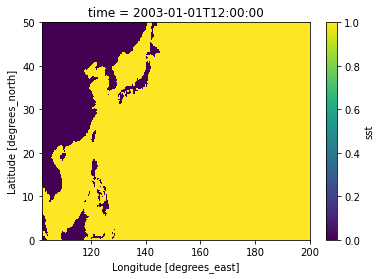

In [34]:
mask_ocean = 1 * np.ones(oisst_subset.shape[1:]) * np.isfinite(oisst_subset.isel(time=0))
mask_land = 0 * np.ones(oisst_subset.shape[1:]) * np.isnan(oisst_subset.isel(time=0))
mask = mask_ocean + mask_land
mask = mask.chunk({'lat': 25, 'lon': 25})
mask.plot()

# Preprocess

In [75]:
%%time
climatology = oisst_subset.groupby(oisst_subset.time.dt.month).mean()
anomaly = oisst_subset.groupby(oisst_subset.time.dt.month) - climatology

anomaly.load()
# 3 years of data (clim + anom calc): 5min 6s total time (25x25x2 chunks)
# 3 years of data (clim + anom calc): 38.2s (default chunks) *gasp*

CPU times: user 32.6 s, sys: 6.53 s, total: 39.2 s
Wall time: 2min 31s


<xarray.DataArray 'sst' (time: 1096, lat: 200, lon: 392)>
array([[[        nan,         nan,         nan, ...,  0.9124718 ,
          0.96580696,  1.2312927 ],
        [        nan,         nan,         nan, ...,  0.95505524,
          1.0866642 ,  1.2886028 ],
        [        nan,         nan,         nan, ...,  1.1009674 ,
          1.2477398 ,  1.3808594 ],
        ...,
        [        nan,         nan,         nan, ...,  0.02623653,
          0.04752684,  0.079247  ],
        [        nan,         nan,         nan, ...,  0.03118277,
          0.08440828,  0.10645151],
        [        nan,         nan,         nan, ...,  0.1347313 ,
          0.10720396,  0.11677408]],

       [[        nan,         nan,         nan, ...,  0.40247154,
          0.34580803,  0.4012928 ],
        [        nan,         nan,         nan, ...,  0.39505577,
          0.37666512,  0.4186039 ],
        [        nan,         nan,         nan, ...,  0.48096848,
          0.45774078,  0.49086   ],
...
        [        nan,         nan,         nan, ...,  0.34752703,
          0.45118237,  0.53032255],
        [        nan,         nan,         nan, ...,  0.36688137,
          0.48247337,  0.57215023],
        [        nan,         nan,         nan, ...,  0.34430122,
          0.39290285,  0.42784882]],

       [[        nan,         nan,         nan, ..., -1.78129   ,
         -1.770216  , -1.7375278 ],
        [        nan,         nan,         nan, ..., -1.8958054 ,
         -1.8640862 , -1.8774204 ],
        [        nan,         nan,         nan, ..., -1.8820438 ,
         -1.9725819 , -1.9809647 ],
        ...,
        [        nan,         nan,         nan, ...,  0.3175273 ,
          0.37118244,  0.41032267],
        [        nan,         nan,         nan, ...,  0.3268814 ,
          0.39247322,  0.43215036],
        [        nan,         nan,         nan, ...,  0.29430103,
          0.31290293,  0.31784868]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 0.125 0.375 0.625 0.875 ... 49.12 49.38 49.62 49.88
  * lon      (lon) float32 102.1 102.4 102.6 102.9 ... 199.1 199.4 199.6 199.9
  * time     (time) datetime64[ns] 2003-01-01T12:00:00 ... 2005-12-31T12:00:00
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12

percentile = .9
threshold = oisst_subset.groupby(oisst_subset.time.dt.month).quantile(percentile, dim='time', keep_attrs=True, skipna=True)
hot_water = anomaly.groupby(oisst_subset.time.dt.month).where(oisst_subset.groupby(oisst_subset.time.dt.month)>threshold)


In [84]:
anomaly

<xarray.DataArray 'sst' (time: 1096, lat: 200, lon: 392)>
array([[[        nan,         nan,         nan, ...,  0.9124718 ,
          0.96580696,  1.2312927 ],
        [        nan,         nan,         nan, ...,  0.95505524,
          1.0866642 ,  1.2886028 ],
        [        nan,         nan,         nan, ...,  1.1009674 ,
          1.2477398 ,  1.3808594 ],
        ...,
        [        nan,         nan,         nan, ...,  0.02623653,
          0.04752684,  0.079247  ],
        [        nan,         nan,         nan, ...,  0.03118277,
          0.08440828,  0.10645151],
        [        nan,         nan,         nan, ...,  0.1347313 ,
          0.10720396,  0.11677408]],

       [[        nan,         nan,         nan, ...,  0.40247154,
          0.34580803,  0.4012928 ],
        [        nan,         nan,         nan, ...,  0.39505577,
          0.37666512,  0.4186039 ],
        [        nan,         nan,         nan, ...,  0.48096848,
          0.45774078,  0.49086   ],
...
        [        nan,         nan,         nan, ...,  0.34752703,
          0.45118237,  0.53032255],
        [        nan,         nan,         nan, ...,  0.36688137,
          0.48247337,  0.57215023],
        [        nan,         nan,         nan, ...,  0.34430122,
          0.39290285,  0.42784882]],

       [[        nan,         nan,         nan, ..., -1.78129   ,
         -1.770216  , -1.7375278 ],
        [        nan,         nan,         nan, ..., -1.8958054 ,
         -1.8640862 , -1.8774204 ],
        [        nan,         nan,         nan, ..., -1.8820438 ,
         -1.9725819 , -1.9809647 ],
        ...,
        [        nan,         nan,         nan, ...,  0.3175273 ,
          0.37118244,  0.41032267],
        [        nan,         nan,         nan, ...,  0.3268814 ,
          0.39247322,  0.43215036],
        [        nan,         nan,         nan, ...,  0.29430103,
          0.31290293,  0.31784868]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 0.125 0.375 0.625 0.875 ... 49.12 49.38 49.62 49.88
  * lon      (lon) float32 102.1 102.4 102.6 102.9 ... 199.1 199.4 199.6 199.9
  * time     (time) datetime64[ns] 2003-01-01T12:00:00 ... 2005-12-31T12:00:00
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12

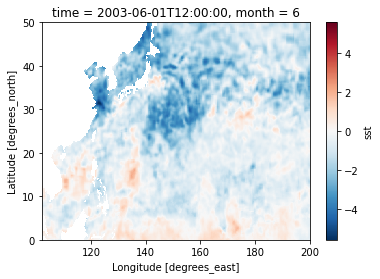

In [71]:
anomaly.sel(time='2003-06-01').plot()

In [89]:
oisst_subset.chunk(dict(time=-1))

<xarray.DataArray 'sst' (time: 1096, lat: 200, lon: 392)>
dask.array<rechunk-merge, shape=(1096, 200, 392), dtype=float32, chunksize=(1096, 200, 392), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 0.125 0.375 0.625 0.875 ... 49.12 49.38 49.62 49.88
  * lon      (lon) float32 102.1 102.4 102.6 102.9 ... 199.1 199.4 199.6 199.9
  * time     (time) datetime64[ns] 2003-01-01T12:00:00 ... 2005-12-31T12:00:00
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius
    valid_max:  4500
    valid_min:  -300

In [92]:
%%time
percentile = .9
# .chunk(dict(time=-1)) fixes the 0 dim parallel error
oisst_subset = oisst_subset.chunk(dict(time=-1))
threshold = oisst_subset.groupby(oisst_subset.time.dt.month).quantile(percentile, 
                                                                      dim='time', 
                                                                      keep_attrs=True, 
                                                                      skipna=True,
                                                                     )

hot_water = anomaly.groupby(oisst_subset.time.dt.month).where(
    oisst.groupby(oisst_subset.time.dt.month)>threshold
)

hot_water.load()


ValueError: the group variable's length does not match the length of this variable along its dimension

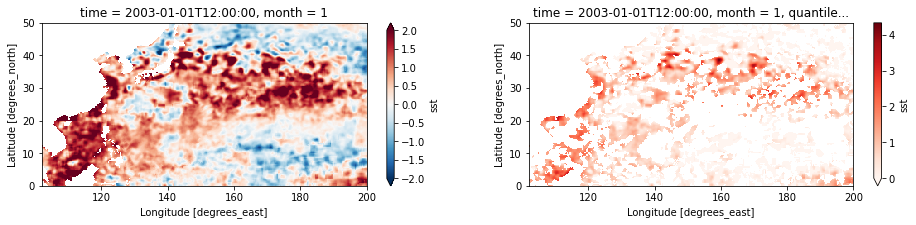

In [16]:
# Visualize
plt.figure(figsize=(16,3))

ax1 = plt.subplot(121);anomaly.isel(time=0).plot(cmap='RdBu_r', vmin=-2, vmax=2, extend='both')
# mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False); ax1.set_aspect('equal');

ax2 = plt.subplot(122); hot_water.isel(time=0).plot(cmap='Reds', vmin=0);
# mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False); ax2.set_aspect('equal');

## Run Ocetrac

In [17]:
hot_water = hot_water.rename({'lon':'x', 'lat':'y'})

In [27]:
hot_water

<xarray.DataArray 'sst' (time: 3, y: 200, x: 392)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan, 1.2886028 ],
        [       nan,        nan,        nan, ..., 1.1009674 ,
         1.2477398 , 1.3808594 ],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ..., 1.2824726 ,
         1.2658081 , 1.2712917 ],
        [       nan,        nan,        nan, ..., 1.1450558 ,
         1.1466637 ,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.11623669,
         0.13752699, 0.1592474 ],
        [       nan,        nan,        nan, ..., 0.1611824 ,
         0.18440866, 0.22645187],
        [       nan,        nan,        nan, ..., 0.20473099,
         0.20720387, 0.21677399]]], dtype=float32)
Coordinates:
  * y         (y) float32 0.125 0.375 0.625 0.875 ... 49.12 49.38 49.62 49.88
  * x         (x) float32 102.1 102.4 102.6 102.9 ... 199.1 199.4 199.6 199.9
  * time      (time) datetime64[ns] 2003-01-01T12:00:00 ... 2003-01-03T12:00:00
    month     int64 1
    quantile  float64 0.9

In [20]:
%%time
Tracker = ocetrac.Tracker(hot_water, mask, radius=2, min_size_quartile=0.75, timedim = 'time', xdim = 'x', ydim='y', positive=True)
blobs = Tracker.track()

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.92 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.51 GiB -- Worker memory limit: 4.00 GiB
distr

KilledWorker: ("('vectorize_get_labels-vectorize_get_labels_0-transpose-e5fa5f5b384e3b2cf6508ffe365268fe', 0, 0, 0, 0, 0)", <WorkerState 'tcp://10.104.169.20:53275', name: 2, memory: 0, processing: 1>)